In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib.cm as cm
import seaborn as sns

In [2]:
curry_df = pd.read_csv("/Users/Owen Hom/Documents/data/archive/3_stephen_curry_shot_chart_2023.csv")

curry_df['shot_type'] = curry_df['shot_type'].replace({2: '2-point shot', 3: '3-point shot'})

curry_df['result'] = curry_df['result'].replace({True: 'Made', False: 'Missed'})

print(curry_df.head())

   top  left          date      qtr time_remaining  result     shot_type  \
0   63   300  Oct 18, 2022  1st Qtr           7:27  Missed  2-point shot   
1  133   389  Oct 18, 2022  1st Qtr           7:22    Made  2-point shot   
2  326   247  Oct 18, 2022  1st Qtr           7:11  Missed  3-point shot   
3  249    89  Oct 18, 2022  1st Qtr           5:16  Missed  3-point shot   
4  282   158  Oct 18, 2022  1st Qtr           3:52  Missed  3-point shot   

   distance_ft  lead  lebron_team_score  opponent_team_score opponent team  \
0            6  True                  9                    6      LAL  GSW   
1           17  True                 11                    6      LAL  GSW   
2           27  True                 11                    6      LAL  GSW   
3           25  True                 19                   13      LAL  GSW   
4           24  True                 22                   17      LAL  GSW   

   season  color  
0    2023    red  
1    2023  green  
2    2023    red 

C:\Users\Owen Hom\AppData\Local\Temp\ipykernel_3536\3263434491.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='shot_type', data=curry_df, palette='viridis')


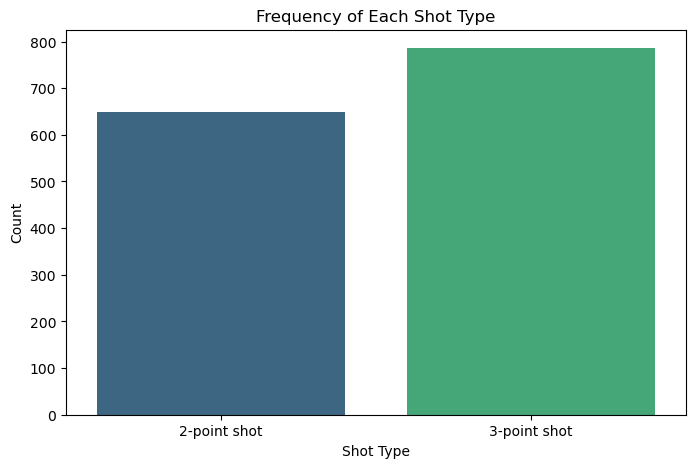

In [3]:
# Bar Chart 1: Frequency of Each Shot Type
plt.figure(figsize=(8,5))
sns.countplot(x='shot_type', data=curry_df, palette='viridis')
plt.title("Frequency of Each Shot Type")
plt.xlabel("Shot Type")
plt.ylabel("Count")
plt.show()

<Axes: xlabel='shot_type'>

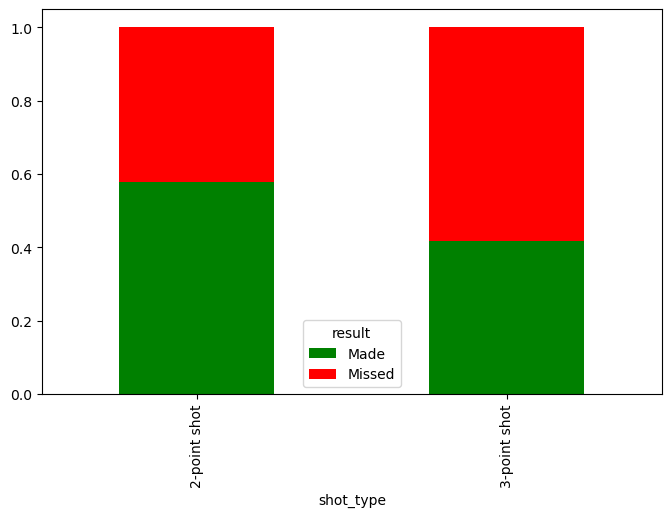

In [4]:
# Bar Chart 2: Shooting Accuracy by Shot Type

# Group by shot_type and result, calculate percentage
accuracy_by_type = curry_df.groupby('shot_type')['result'].value_counts(normalize=True).unstack().fillna(0)

# Plot as grouped bar chart
accuracy_by_type[['Made', 'Missed']].plot(kind='bar',
                                          stacked=True,
                                          color=['green', 'red'],
                                          figsize=(8,5))

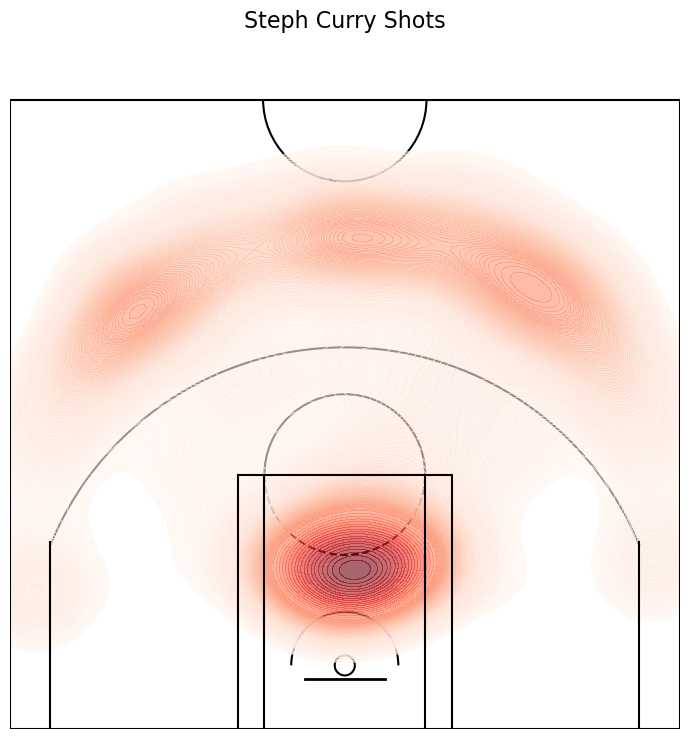

In [6]:
# ---- Coordinate conversion function ----

def convert_coords(df):
    """
    Converts shot coordinates from image-based space to court space
    
    Assumes:
    - 'left' ranges from 0 to ~480 (image pixels) → center it around 0
    - 'top' already increases from basket to halfcourt, so no flip needed
    """
    df['court_x'] = df['left'] - 240   # Center X around 0 to match court
    df['court_y'] = df['top']         # Y is already in the correct direction
    
    return df

# Apply coordinate conversion to Curry's shot data
curry_df = convert_coords(curry_df)

# --- Court Drawing Function ---

def draw_nba_court(axis=None):
    """
    Draws an NBA halfcourt using matplotlib primitives.

    Args:
        axis (matplotlib axis): Optional axis to draw on. Creates one if not provided.

    Returns:
        fig, axis: Figure and axis with the court drawn
    """
    if axis is None:
        fig = plt.figure(figsize=(9, 9))
        axis = fig.add_subplot(111, aspect='auto')
    else:
        fig = None

    # --- Court Outline (Baseline, Sidelines, Halfcourt Line) ---
    axis.plot([-250, 250], [-47.5, -47.5], 'k-')     # Baseline
    axis.plot([-250, -250], [-47.5, 422.5], 'k-')    # Left sideline
    axis.plot([250, 250], [-47.5, 422.5], 'k-')      # Right sideline
    axis.plot([-250, 250], [422.5, 422.5], 'k-')     # Halfcourt line

    # --- Backboard ---
    axis.plot([-30, 30], [-10, -10], 'k-', lw=2)

    # --- Paint / Lane ---
    axis.plot([-80, -80], [-47.5, 142.5], 'k-')
    axis.plot([80, 80], [-47.5, 142.5], 'k-')
    axis.plot([-60, -60], [-47.5, 142.5], 'k-')
    axis.plot([60, 60], [-47.5, 142.5], 'k-')
    axis.plot([-80, 80], [142.5, 142.5], 'k-')     # Free throw line

    # --- Hoop and Restricted Area ---
    hoop = Arc((0, 0), 15, 15, theta1=0, theta2=360, lw=1.5, color='black')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, lw=1.5, color='black')
    axis.add_patch(hoop)
    axis.add_patch(restricted)

    # --- Free Throw Circle ---
    axis.add_patch(Arc((0, 142.5), 120, 120, theta1=0, theta2=180, lw=1.5, color='black'))     # Top half
    axis.add_patch(Arc((0, 142.5), 120, 120, theta1=180, theta2=360, lw=1.5, linestyle='--', color='black'))  # Bottom half (dashed)

    # --- 3-Point Lines ---
    axis.plot([-220, -220], [-47.5, 92.5], 'k-')     # Left corner 3
    axis.plot([220, 220], [-47.5, 92.5], 'k-')       # Right corner 3
    axis.add_patch(Arc((0, 0), 475, 475, theta1=22, theta2=158, lw=1.5, color='black'))   # 3-pt arc

    # --- Halfcourt Circle ---
    axis.add_patch(Arc((0, 422.5), 122, 122, theta1=180, theta2=360, lw=1.5, color='black'))

    # --- Axis Settings ---
    axis.set_xlim(-250, 250)
    axis.set_ylim(-47.5, 470)
    axis.set_aspect(1)     # Equal aspect ratio
    axis.axis('off')       # Hide axes

    return fig, axis

# --- Heatmap Visualization ---

# Create plot and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Draw halfcourt on axis
draw_nba_court(ax)

# Overlay KDE heatmap of Curry's shot locations
kde = sns.kdeplot(
    x=curry_df['court_x'], 
    y=curry_df['court_y'], 
    fill=True, 
    cmap='Reds', 
    bw_adjust=0.8, 
    alpha=0.6, 
    levels=100, 
    thresh=0.05, 
    ax=ax
)

plt.title("Steph Curry Shots", fontsize=16)
plt.show()